# 사전 학습된 CNN(VGG-16)을 이용한 Feature Extraction

### VGG-16 Model
- University of Oxford - Visual Geometry Group
- 2014 ILSVRC 2nd Model
- ImageNet Large Scale Visual Recognition Challenge (ILSVRC)

### Dogs and Cats small dataset에 VGG16 모델 적용

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import tensorflow as tf

tf.__version__

### 사전 훈련된 컨브넷 사용

- 작은 이미지 데이터셋에 딥러닝을 적용하는 일반적이고 매우 효과적인 방법은 사전 훈련된 네트워크를 사용하는 것임
- 사전 훈련된 네트워크(pretrained network)
  - 대규모 이미지 분류 문제를 위해 대량의 데이터셋에서 미리 훈련되어 저장된 네트워크
  - 원본 데이터셋이 충분히 크고 일반적이라면 사전 훈련된 네트워크에 의해 학습된 특성의 계층구조는 일반적인 모델로 효율적인 역할 가능

- 사전 훈련된 네트워크 사용 방법
  - 특성 추출
  - 미세 조정

### VGG16 모델
- keras의 applications 모듈에서 제공
  - Xception
  - Inception V3
  - ResNet50
  - VGG16
  - VGG19
  - MobileNet
- ImageNet의 클래스 집합에는 여러 종류의 강아지와 고양이를 포함하고 있어 원본 모델의 완전 연결층에 있는 정보를 재사용하는 것이 도움이 될 수 있으나, 일반적인 경우를 다루기 위해 완전 연결층을 사용하지 않고 합성곱 층만 사용

- VGG16(weights='', include_top=True, input_shape=()}
  - weights : 모델을 초기화할 가중치 체크포인트 지정
  - include_top : 네트워크의 최상위 완전 연결분류기를 포함할지 여부 결정. 기본값은 포함(True)
  - input_shape : 네트워크에 주입할 이미지 텐서 크기
    - 이 값을 지정하지 않으면 네트워크가 어떤 크기의 입력도 처리할 수 있음

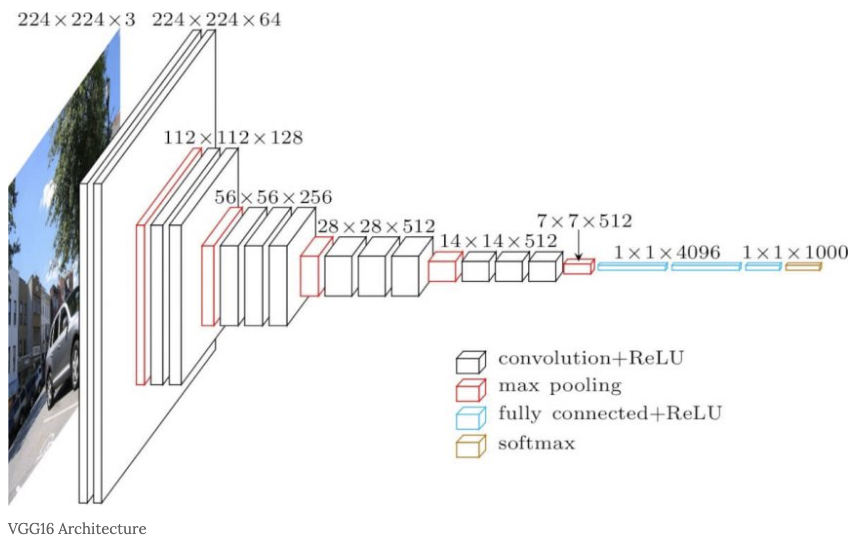

In [ ]:
# VGG16 합성곱 기반 층 만들기

from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [ ]:
conv_base.summary()

- VGG16의 컨브넷 최종 특성 맵의 크기 : (4, 4, 512)

###  conv_base를 이용하는 두 가지 방식
  - 방법1. 새로운 데이터셋에 합성곱 기반 층을 실행하고 출력을 넘파이 배열로 디스크에 저장한 후, 독립된 완전연결분류기에 입력으로 사용


  - 방법2. 준비한 모델(conv_base) 위에 Dense 층을 쌓아 확장한 후, 입력 데이터에서 end-to-end로 전체모델을 실행


### **[방법1] 데이터 증식을 사용하지 않는 빠른 특성 추출**

- ImageDataGenerator를 사용하여 이미지와 레이블을 넘파이 배열로 추출
- conv_base 모델의 predict 메서드를 호출하여 이 이미지에서 특성 추출
- 추출된 특성을 완전 연결 분류기에 주입하고 훈련

#### 0. 디렉토리 설정

In [ ]:
import os
import numpy as np

base_dir ='./datasets/cats_and_dogs_small'
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

#### 1. 사전 훈련된 합성곱 기반 층을 사용한 특성 추출

In [ ]:
# ImageDataGenerator를 사용하여 이미지와 레이블 넘파이 배열로 추출

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size=20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
  
    generator = datagen.flow_from_directory(directory,
                                            target_size=(150, 150),
                                            batch_size=batch_size,
                                            class_mode='binary')

    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_size:(i+1)*batch_size] = features_batch
        labels[i*batch_size:(i+1)*batch_size] = labels_batch

        i+=1
        if i * batch_size >= sample_count:
            break

    return features, labels

In [ ]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

In [ ]:
train_features.shape, validation_features.shape, test_features.shape

#### 2. 완전 연결 분류기에 특성 주입하기 위해 (samples, 8192)로 펼치기


In [ ]:
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

In [ ]:
train_features.shape, validation_features.shape, test_features.shape

#### 3. 완전 연결 분류기 정의하고 훈련

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(Dense(256, activation='relu', input_dim=4*4*512))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(learning_rate=2e-05),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

#### 4.모델 성능 시각화
- 훈련, 검증의 손실과 정확도

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# 모델의 훈련과 검증데이터의 정확도 그래프

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(9,6))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# 모델의 훈련과 검증데이터의 손실 그래프

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(9,6))

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

#### 5. 모델 평가

In [ ]:
loss, accuracy = model.evaluate(test_features, test_labels)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

#### 6. 모델 저장

- 모델 저장하기 : model.save()


In [ ]:
model.save('model/cats_and_dogs_small_vgg16_feature_ext.h5')

---

### [방법2] 데이터 증식을 사용한 특성 추출

- GPU 사용
- 연산 비용이 많이 듬
- conv_base 모델 확장

#### 1. 데이터 증식을 위한 설정

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range =0.1,
    horizontal_flip = True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size = 20,
    class_mode = 'binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode = 'binary'
)

#### 2. conv_base 기반 모델  

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

#### 3. 모델의 합성곱 기반 층을 동결

In [ ]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수:', len(model.trainable_weights))

In [ ]:
conv_base.trainable = False

In [ ]:
print('conv_base를 동결한 후 훈련되는 가중치의 수:', len(model.trainable_weights))

#### 4. 동결된 합성곱 기반 층과 함께 모델 훈련

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=2e-05),
              metrics=['acc'])

history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=30,
    verbose=2
)

=> 검증 결과 정확도 91%

#### 5. 모델 성능 시각화

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# 모델의 훈련과 검증데이터의 정확도 그래프

acc = history.history['acc']
val_acc = history.history['val_acc']


epochs = range(1, len(acc) + 1)

plt.figure(figsize=(9,6))

plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# 모델의 훈련과 검증데이터의 손실 그래프

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(9,6))

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

#### 6. 모델 저장

In [ ]:
model.save('model/cats_and_dogs_small_vgg16_feature_ext2.h5')

#### 7. 모델 평가

- 테스트 데이터

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
                 test_dir,
                 target_size = (150, 150),
                 batch_size = 20,
                 class_mode = 'binary')

- 모델 로드

In [ ]:
from tensorflow.keras.models import load_model

model2 = load_model('./model/cats_and_dogs_small_vgg16_feature_ext2.h5')

- 모델 평가

In [ ]:
loss, accuracy = model2.evaluate(test_generator,
                                steps = 50)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))